In [1]:
#Import Libraries
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
#Import dataset
DE = pd.read_csv('cleaned_delay_events.csv')

In [3]:
def get_sample(dataset, frac=0.1):
    """Chooses a fraction of dataset randomly and performs the steps necessary to get to applying clustering."""
    if frac < 1.0: df = DE.sample(frac=frac)
    else: df = DE
    
    X_s = preprocessing.scale(df)
    
    # Dimensionality Reduction:
    pca = decomposition.PCA(n_components=.85, svd_solver='full')
    model = pca.fit(X_s)
    
    return (model.transform(X_s), df, X_s, model)

In [4]:
sample = get_sample(DE, 0.02)
X_r, cmp = sample

# Figuring out the "important" features in PCA

Is it fair to say important means coefficient in a PC >= some threshold ?

In [9]:
all_coef = np.abs(cmp).reshape(-1, 1)
all_coef.shape

(1568, 1)

Can we figure out the threshold by sticking with "significantly less likely" than values below it?

(array([491., 231., 180., 121., 108.,  85.,  52.,  50.,  24.,  30.,  22.,
         30.,  31.,  14.,  18.,  15.,  18.,   6.,   6.,   3.,   2.,   7.,
          2.,   8.,   1.,   1.,   2.,   3.,   1.,   1.,   3.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 ]),
 <a list of 40 Patch objects>)

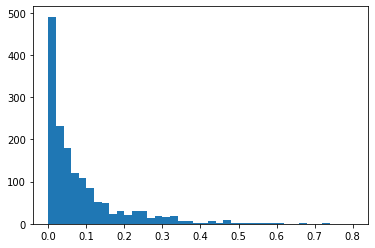

In [10]:
# Histogram of absolute value of coefficients in cmp
plt.hist(all_coef, bins=40, range=(0.0, 0.8))

(array([ 0.,  0.,  0.,  0.,  0., 52., 45., 33., 24.,  9.,  9., 10.,  2.,
         5.,  2.,  3.,  1.,  0.,  1.,  0.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 ]),
 <a list of 20 Patch objects>)

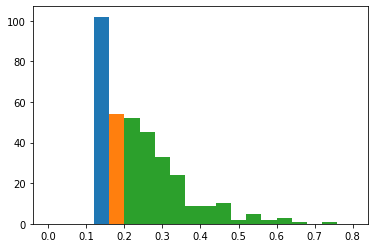

In [11]:
# Histogram of absolute value of coefficients bigger than 0.12 in cmp
plt.hist(all_coef[all_coef >= 0.12], bins=20, range=(0.0, 0.8))
# Histogram of absolute value of coefficients bigger than 0.16 in cmp
plt.hist(all_coef[all_coef >= 0.16], bins=20, range=(0.0, 0.8))
# Histogram of absolute value of coefficients bigger than 0.2 in cmp
plt.hist(all_coef[all_coef >= 0.2], bins=20, range=(0.0, 0.8))

(array([  0.,   0.,   0., 121., 108.,  85.,  52.,  50.,  24.,  30.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <a list of 10 Patch objects>)

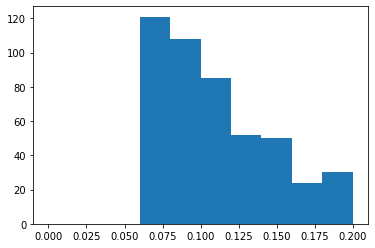

In [12]:
# Histogram of absolute value of coefficients less than 0.2 and bigger than 0.06
plt.hist(all_coef[(all_coef <= 0.2) & (0.06 <= all_coef)], bins=10, range=(0.0, 0.2))

In [14]:
n_pcs = cmp.shape[0]
for i in range(n_pcs):
    print(i)
    print('largest', np.round(np.abs(cmp[i]).max(), 2))
    print('tenth largest:',np.round(np.unique(np.abs(cmp[i]))[-10], 2))
    print('median:', np.round(np.median(np.abs(cmp[i])), 2))
    print ('*********************')

0
largest 0.34
tenth largest: 0.16
median: 0.03
*********************
1
largest 0.32
tenth largest: 0.23
median: 0.06
*********************
2
largest 0.32
tenth largest: 0.22
median: 0.08
*********************
3
largest 0.37
tenth largest: 0.1
median: 0.03
*********************
4
largest 0.3
tenth largest: 0.21
median: 0.08
*********************
5
largest 0.38
tenth largest: 0.22
median: 0.07
*********************
6
largest 0.46
tenth largest: 0.16
median: 0.04
*********************
7
largest 0.33
tenth largest: 0.19
median: 0.06
*********************
8
largest 0.47
tenth largest: 0.12
median: 0.04
*********************
9
largest 0.33
tenth largest: 0.21
median: 0.08
*********************
10
largest 0.3
tenth largest: 0.22
median: 0.05
*********************
11
largest 0.6
tenth largest: 0.12
median: 0.05
*********************
12
largest 0.38
tenth largest: 0.18
median: 0.09
*********************
13
largest 0.48
tenth largest: 0.15
median: 0.04
*********************
14
largest 0.62
tent

So, it seems like setting threshold around 0.1 doesn't make a lot of information be lost.

In [15]:
important = []
# number of components
n_pcs = cmp.shape[0]
for i in range (n_pcs):
    for j in range (cmp.shape[1]):
        value_j = np.abs(cmp[i][j])
        if value_j >= 0.1:
            important.append ((i, j, np.round(np.abs(value_j), 2)))

In [16]:
important = []
# number of components
n_pcs = cmp.shape[0]
for i in range (n_pcs):
    for j in range (cmp.shape[1]):
        value_j = np.abs(cmp[i][j])
        if value_j >= 0.1:
            important.append ((i, j, np.round(np.abs(value_j), 2)))

In [17]:
freq = [x[1] for x in important]
freq.sort()
feature_freq = {i:freq.count(i) for i in freq}
print(feature_freq)
print(len(feature_freq))

{0: 7, 1: 9, 2: 6, 3: 11, 4: 9, 5: 13, 6: 8, 7: 8, 8: 6, 9: 9, 10: 13, 11: 8, 12: 8, 13: 7, 14: 8, 15: 7, 16: 8, 17: 5, 18: 8, 19: 7, 20: 5, 21: 10, 22: 11, 23: 10, 24: 2, 25: 2, 26: 9, 27: 12, 28: 7, 29: 13, 30: 9, 31: 8, 32: 11, 33: 6, 34: 9, 38: 11, 39: 13, 41: 7, 42: 9, 44: 8, 45: 8, 46: 7, 47: 10, 48: 8, 49: 7, 50: 8, 51: 10, 52: 11, 53: 8, 54: 13, 55: 10}
51


So, most features have appeared a reasonable number of times as "important". So, we cannot conclude anything from this line.

# K-means 

I would like to choose the number of clusters using silhouette score. However, the comutation for the entire dataset is very heavy. So I did this calculation for 10% of data a few times, and the results were consistent each time. They all suggested that best silhouette score for $k > 3$ is around $0.15$ and for larger $k$'s it is around $0.09$. So, the score is typically low, and not very differentiating. Another recurrent theme is that for $k > 10$ the score tends to drop, definitely so for $k > 15$. Below, the plot for one of these calculations is displayed:

In [5]:
score = []
for k in range(2, 41):
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(X_r)
    s = silhouette_score(X_r, y_pred)
    score.append (s)

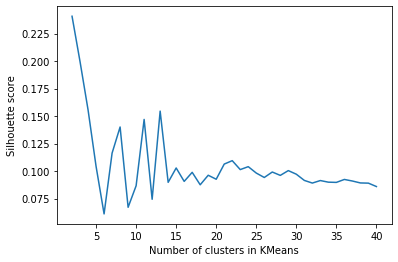

In [7]:
plt.plot(np.arange(2, 41), score)
plt.xlabel('Number of clusters in KMeans')
plt.ylabel('Silhouette score')
plt.show()

The score for smaller number of clusters is better. So, let's have a closer look at these numbers:

# On all data

In [ ]:
# Note: We are asking for decomposition.PCA(n_components=.85, svd_solver='full') in code
sample = get_sample(DE, 1)
X = sample[0]
X.shape

Now that I am working on all data, I will limit the silhouette score calculation to be done on 0.1 of data.

In [ ]:
sample_size = 50000 #For silhouette score
kmeans_inertia, kmeans_ch_score, kmeans_db_score, kmeans_s_score = [], [], [],[]
for k in range(2, 28):
    
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(X)
    
    kmeans_inertia.append((k,-kmeans.score(X)))

    db = davies_bouldin_score(X, y_pred)
    ch = metrics.calinski_harabasz_score(X, y_pred)
    s = silhouette_score(X, y_pred, sample_size=sample_size)
    kmeans_ch_score.append((k,ch))
    kmeans_db_score.append((k, db))
    kmeans_s_score.append((k, s))

### From sklearn documentation:
A  lower Davies-Bouldin index relates to a model with better separation between the clusters. This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

The CH score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

In [ ]:
plt.plot([x[0] for x in kmeans_db_score], [x[1] for x in kmeans_db_score] , marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin index')
plt.title('KMeans(n_init=10)')
plt.grid()
plt.savefig('DB-index-KMeans.png', dpi=150)
plt.show()

In [ ]:
plt.plot([x[0] for x in kmeans_ch_score], [x[1] for x in kmeans_ch_score] , marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.title('KMeans(n_init=10)')
plt.grid()
plt.savefig('CH-score-KMeans.png', dpi=150)
plt.show()

In [ ]:
plt.plot([x[0] for x in kmeans_inertia], [x[1] for x in kmeans_inertia], marker ='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('KMeans(n_init=10)')
plt.grid()
plt.savefig('Inertia-KMeans.png', dpi=150)
plt.show()

In [ ]:
plt.plot([x[0] for x in kmeans_s_score], [x[1] for x in kmeans_s_score] , marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score(comuted on 10% of data)')
plt.title('KMeans(n_init=10)')
plt.grid()
plt.savefig('silh-index-KMeans.png', dpi=150)
plt.show()

Looking at the figures, we get an idea of what a 'differentiating' threshold for each score is.

In [ ]:
better_ch_score = [x[0] for x in kmeans_ch_score if x[1] > 31500]
better_s_score = [x[0] for x in kmeans_s_score if x[1] >= 0.09]
lower_db_index = [x[0] for x in kmeans_db_score if x[1] < 2.3]
kmeans_chosen = [x for x in better_ch_score if x in lower_db_index]
kmeans_chosen

Now, we are going to look more closely at these cases. In particular, we are going to increase n_init from the default 10 to 15.

At the end of the day, we would like to be able to infer things in relation to the dataset features, not PCA. So, we need a function that does this:

In [ ]:
feature_to_pca = sample[3].components_
feature_to_pca.shape

In [ ]:
def pca_coef_to_feature(L, feature_to_pca):
    """Takes a list of arrays in PC basis and the PC coordinates in feature basis.
    Returns the list of arrays in feature basis."""
    
    back_to_feature = []
    
    for a in L:
        back_to_feature_a = []
        for j in range(feature_to_pca.shape[1]):
            coef_j = 0
            for i in range(a.shape[0]):
                coef_j += a[i] * feature_to_pca[i, j]
            back_to_feature_a.append(coef_j)
        back_to_feature.append(back_to_feature_a)
    return np.array(back_to_feature)

In [ ]:
kmeans_ch_chosen, kmeans_db_chosen, kmeans_s_chosen = [], [], []
kmeans_info = pd.DataFrame(index=DE.index)
centroid = pd.DataFrame(columns=DE.columns)

for k in kmeans_chosen:
    kmeans = KMeans(n_clusters=k, n_init=15)
    y_pred = kmeans.fit_predict(X)
    
    kmeans_info['cluster_kmeans_%d' %k] = pd.Series(y_pred)
    
    centroid_k = pd.DataFrame(pca_coef_to_feature(kmeans.cluster_centers_, feature_to_pca),
                              index={'%d th centroid_kmenas_%d' %(i, k)  for i in range(k)},
                             columns=DE.columns)
    centroid = centroid.append(centroid_k)

    kmeans_db_chosen.append((k, davies_bouldin_score(X, y_pred)))
    kmeans_ch_chosen.append((k, metrics.calinski_harabasz_score(X, y_pred)))
    kmeans_s_chosen.append((k, silhouette_score(X, y_pred, sample_size=sample_size)))

    distance = []
    for i in range(y_pred.shape[0]):
        d_i = np.sum(np.square(X[i] - kmeans.cluster_centers_[y_pred[i]]))
        distance.append(d_i)

    kmeans_info['distance_to_centroid_kmeans_%d' %k] = pd.Series(np.array(distance))
kmeans_info.to_csv('best_kmeans_info.csv')
centroid.to_csv('best_kmeans_centroid.csv')

In [ ]:
plt.plot([x[0] for x in kmeans_ch_score], [x[1] for x in kmeans_ch_score] , marker = 'o', label='KMeans(n_init=10)')
plt.plot([x[0] for x in kmeans_ch_chosen], [x[1] for x in kmeans_ch_chosen] , marker = 'o', label='KMeans(n_init=15)')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.title('KMeans on all data')
plt.grid()
plt.legend()
plt.savefig('CH-score-KMeans_2.png')
plt.show()

In [ ]:
plt.plot([x[0] for x in kmeans_db_score], [x[1] for x in kmeans_db_score] , marker = 'o', label='KMeans(n_init=10)')
plt.plot([x[0] for x in kmeans_db_chosen], [x[1] for x in kmeans_db_chosen] , marker = 'o', label='KMeans(n_init=15)')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin index')
plt.title('KMeans on all data')
plt.grid()
plt.legend()
plt.savefig('DB-index-KMeans_2.png')
plt.show()

In [ ]:
plt.plot([x[0] for x in kmeans_s_score], [x[1] for x in kmeans_s_score] , marker = 'o', label='KMeans(n_init=10)')
plt.plot([x[0] for x in kmeans_s_chosen], [x[1] for x in kmeans_s_chosen] , marker = 'o', label='KMeans(n_init=15)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('KMeans(computed on 10% of data)')
plt.grid()
plt.savefig('silh-index-KMeans_2.png', dpi=150)
plt.show()

# Using Bayesian Gaussian Mixture Models for finding appropriate k

In [13]:
from sklearn.mixture import BayesianGaussianMixture

In [15]:
for k in range(1, 11):
    bgm = BayesianGaussianMixture(n_components=k)
    bgm.fit(X_r)
    print(np.round(bgm.weights_, 2))

[1.]
[0.89 0.11]
[0.89 0.02 0.09]
[0.17 0.02 0.73 0.08]
[0.01 0.08 0.16 0.7  0.05]
[0.01 0.8  0.06 0.01 0.12 0.  ]
[0.73 0.06 0.05 0.03 0.06 0.05 0.02]
[0.03 0.07 0.65 0.   0.04 0.   0.02 0.2 ]
[0.04 0.06 0.   0.   0.05 0.66 0.01 0.03 0.14]
[0.1  0.02 0.05 0.06 0.   0.5  0.   0.   0.26 0.  ]


I observe that for $k>7$ I always get a component of weight < 0.02, so I'm going with $k=7$ or $k=8$.

In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
bgm_8= BayesianGaussianMixture(n_components=8, n_init=10)
bgm_8.fit(X)
print(np.round(bgm_8.weights_, 2))

y_pred_8 = bgm_8.predict(X)

print('Davies-Bouldin score for BGM with 8 comonent is', davies_bouldin_score(X, y_pred_8))

It is way worse than the Davies-Bouldin score for KMeans.

In [ ]:
bgm_7 = BayesianGaussianMixture(n_components=7, n_init=10)
bgm_7.fit(X)
print(np.round(bgm_7.weights_, 2))

y_pred_7 = bgm_7.predict(X)
print('Davies-Bouldin score for BGM with 8 comonent is', davies_bouldin_score(X, y_pred_7))

This one is also much worse than Davies-Bouldin score for KMeans, so this is not a good model for this problem.

# DBSCAN

I think min_samples= 5 is reasonable. Let's see what is the distance to fourth closest neighbor for each instance:

In [19]:
nbrs = NearestNeighbors(n_neighbors=5).fit(X_r)
distances, indices = nbrs.kneighbors(X_r)

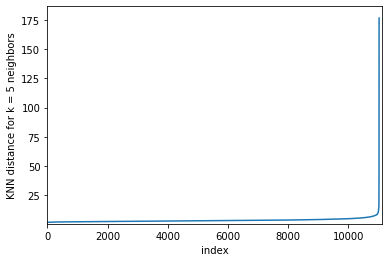

In [34]:
distance_4 = np.sort(distances[:,-1])
index = np.arange(len(distance_4))
plt.plot(index,distance_4)
plt.axis([0, X_r.shape[0] + 100, min(distance_4) - 1, max(distance_4) + 10])
plt.ylabel('KNN distance for k = 5 neighbors')
plt.xlabel('index')
plt.show()

Let's explore what happens if we pick an eps so that p-percentile of instances are cores.

In [59]:
score = []
for p in np.linspace(5, 95, 19):
    eps = np.percentile(distance_4, p)
    print ("With", p, "percent being core, we get eps = ", eps)
    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=5).fit(X_r)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    score_p = metrics.silhouette_score(X_r, labels)
    score.append((eps, score_p))
    
    print('Number of clusters: %d' % n_clusters_)
    print('Number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % score_p)    
    print("*************************************************")

With 5.0 percent being core, we get eps =  2.019994430814881
Number of clusters: 57
Number of noise points: 9768
Silhouette Coefficient: -0.379
*************************************************
With 10.0 percent being core, we get eps =  2.1718211364488007
Number of clusters: 69
Number of noise points: 8842
Silhouette Coefficient: -0.357
*************************************************
With 15.0 percent being core, we get eps =  2.283570917007136
Number of clusters: 66
Number of noise points: 8079
Silhouette Coefficient: -0.331
*************************************************
With 20.0 percent being core, we get eps =  2.387914712996178
Number of clusters: 66
Number of noise points: 7380
Silhouette Coefficient: -0.326
*************************************************
With 25.0 percent being core, we get eps =  2.4862510584119795
Number of clusters: 62
Number of noise points: 6792
Silhouette Coefficient: -0.309
*************************************************
With 30.0 percent being 

None of these gave an acceptable silhouette score. Let's push higher:

In [70]:
for p in np.linspace(96, 99, 4):
    eps = np.percentile(distance_4, p)
    print ("With", p, "percent being core, we get eps = ", eps)
    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=5).fit(X_r)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    score_p = metrics.silhouette_score(X_r, labels)
    score.append((eps, score_p))
    

    print('Number of clusters: %d' % n_clusters_)
    print('Number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % score_p)
    if score_p > 0.2:
        n = labels.shape[0]
        print ("Here is the percent of samples in each cluster:")
        for k in range(n_clusters_):
            cluster_k = [j for j in range(n) if labels[j] == k]
            print (np.around(len(cluster_k)* 100 /n, decimals =2))
    print("*************************************************")

With 96.0 percent being core, we get eps =  5.813798102238144
Number of clusters: 10
Number of noise points: 260
Silhouette Coefficient: 0.248
Here is the percent of samples in each cluster:
93.27
0.08
0.87
1.23
0.66
1.03
0.32
0.05
0.1
0.03
*************************************************
With 97.0 percent being core, we get eps =  6.227200828717898
Number of clusters: 10
Number of noise points: 193
Silhouette Coefficient: 0.286
Here is the percent of samples in each cluster:
94.67
0.9
1.32
0.69
0.35
0.05
0.11
0.06
0.05
0.05
*************************************************
With 98.0 percent being core, we get eps =  6.712775707422658
Number of clusters: 9
Number of noise points: 138
Silhouette Coefficient: 0.294
Here is the percent of samples in each cluster:
94.93
0.93
1.4
0.81
0.42
0.11
0.07
0.05
0.05
*************************************************
With 99.0 percent being core, we get eps =  7.81531380669329
Number of clusters: 7
Number of noise points: 49
Silhouette Coefficient:

So, we only get higher score when the big majority of data gets sucked into one cluster :(

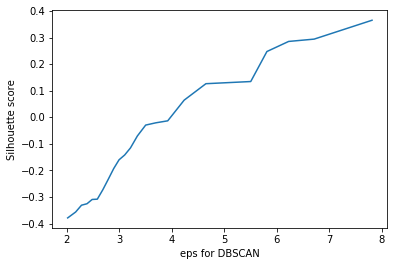

In [71]:
index = [x[0] for x in score]
score_p = [x[1] for x in score]
plt.plot(index, score_p)
plt.xlabel('eps for DBSCAN')
plt.ylabel('Silhouette score')
plt.show()

Morale: It seems like either min_samples must be increased, or simply let go of DBSCAN!

# OPTICS

In [16]:
score = []
for k in [5, 10, 11, 12, 13, 14, 15]:
    opt = OPTICS(min_samples=k)
    y_pred = opt.fit_predict(X_r)
    s = silhouette_score(X_r, y_pred)
    score.append(s)
    print ("For min_samples =", k, "OPTICS gives", len(np.unique(y_pred)), "clusters, and the silhouette score is", np.round(s, 2))
    if s > 0.2:
        for x in np.unique(y_pred):
            print("The percent of cluster", x, 'is', np.round(100*len(y_pred[y_pred == x])/len(X_r), 2))

For min_samples = 5 OPTICS gives 97 clusters, and the silhouette score is -0.42
For min_samples = 10 OPTICS gives 10 clusters, and the silhouette score is -0.08
For min_samples = 11 OPTICS gives 10 clusters, and the silhouette score is 0.08
For min_samples = 12 OPTICS gives 7 clusters, and the silhouette score is 0.4
The percent of cluster -1 is 98.87
The percent of cluster 0 is 0.11
The percent of cluster 1 is 0.43
The percent of cluster 2 is 0.11
The percent of cluster 3 is 0.17
The percent of cluster 4 is 0.18
The percent of cluster 5 is 0.14
For min_samples = 13 OPTICS gives 6 clusters, and the silhouette score is 0.08
For min_samples = 14 OPTICS gives 7 clusters, and the silhouette score is -0.09
For min_samples = 15 OPTICS gives 6 clusters, and the silhouette score is -0.06


Again, the same story :( This is the same story that happened with DBSCAN.